
# ACCT445 Notebook 02 · Decile Analysis

**Objective:** Evaluate whether disclosure opacity (CNOI) predicts forward stock returns, using real yfinance data and the decile backtest utilities built in Phases 1–2.

**Key questions**
- Do low-opacity banks (low CNOI) outperform their opaque peers?
- Which CNOI dimensions (D, G, R, J, T, S, X) drive the long-short spread?
- How sensitive are results to trading-lag assumptions?


## 1. Imports & Environment

In [1]:

from __future__ import annotations

import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if not (PROJECT_ROOT / "config").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from src.analysis.decile_backtest import (
    assign_deciles,
    compute_decile_returns,
    compute_long_short,
    run_decile_backtest,
)
from src.analysis.dimension_analysis import (
    analyze_all_dimensions,
    compare_dimensions,
    plot_dimension_comparison,
)
from src.data.cik_ticker_mapper import enrich_cnoi_with_tickers
from src.utils.data_loader import (
    compute_forward_returns,
    load_cnoi_data,
    merge_cnoi_with_returns,
)
from src.utils.logger import get_logger

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CNOI_PATH = PROJECT_ROOT / "config" / "sample_cnoi.csv"
MARKET_RETURNS_PATH = RESULTS_DIR / "market_returns.csv"

LOGGER = get_logger("notebooks.decile_analysis")


## 2. Load & Enrich CNOI Data

In [2]:

cnoi_raw = load_cnoi_data(str(CNOI_PATH))
cnoi = enrich_cnoi_with_tickers(cnoi_raw)
cnoi["quarter"] = cnoi["filing_date"].dt.to_period("Q")

coverage = cnoi["ticker"].notna().mean() * 100
summary = {
    "total_filings": len(cnoi),
    "issuers": cnoi["issuer"].nunique(),
    "ticker_coverage_pct": coverage,
}

display(pd.Series(summary, name="CNOI Overview"))
cnoi.head()


2025-11-08 16:26:13 - src.utils.validation - INFO - CNOI schema validation passed (411 rows).


2025-11-08 16:26:13 - src.utils.data_loader - INFO - Loaded 411 CNOI rows from /Users/nirvanchitnis/ACCT445-Showcase/config/sample_cnoi.csv


2025-11-08 16:26:13 - src.data.cik_ticker_mapper - INFO - Fetching SEC ticker mapping via cached client


2025-11-08 16:26:13 - src.data.sec_api_client - INFO - Loading SEC mapping from cache (age: 0.8h)


2025-11-08 16:26:13 - src.data.cik_ticker_mapper - INFO - Fetched 7900 company ticker mappings


2025-11-08 16:26:13 - src.data.cik_ticker_mapper - INFO - Loaded 4 manual CIK overrides from /Users/nirvanchitnis/ACCT445-Showcase/config/cik_ticker_overrides.csv


2025-11-08 16:26:13 - src.data.cik_ticker_mapper - INFO - Applied 29 manual ticker overrides.


total_filings          411.0
issuers                 40.0
ticker_coverage_pct    100.0
Name: CNOI Overview, dtype: float64

,cik,accession,form,filing_date,is_pbe,issuer,score,CNOI,D,G,...,ixbrl_has_credit_quality,ixbrl_has_rollforward,ixbrl_has_aging,ixbrl_custom_only,heading_selected_title,heading_selected_score,quarter,ticker,company_name,notes
0,846617,0000846617-23-000018,10-K,2023-02-28,False,"Dime Community Bancshares, Inc. /NY/",13.48,13.48,8.0,30.0,...,False,False,False,NaN,Table of Contents determined based upon the ou...,18.64,2023Q1,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
1,846617,0000846617-23-000040,10-Q,2023-05-08,False,"Dime Community Bancshares, Inc. /NY/",8.95,8.95,0.0,20.0,...,False,False,False,NaN,Table of Contents Selected Financial Highlight...,20.69,2023Q2,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
2,846617,0000846617-23-000059,10-Q,2023-08-02,False,"Dime Community Bancshares, Inc. /NY/",10.47,10.47,4.0,20.0,...,False,False,False,NaN,Table of Contents Allowance for Off-Balance Sh...,18.89,2023Q3,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
3,846617,0000846617-23-000084,10-Q,2023-11-02,False,"Dime Community Bancshares, Inc. /NY/",8.87,8.87,4.0,12.0,...,False,False,False,NaN,Table of Contents Accruing Loans 90 Days or Mo...,20.62,2023Q4,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
4,846617,0000846617-24-000018,10-K,2024-02-22,False,"Dime Community Bancshares, Inc. /NY/",10.33,10.33,8.0,8.0,...,False,False,False,NaN,Table of Contents Past Due Loans Loans Delinqu...,19.24,2024Q1,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN


## 3. Load Market Returns & Compute Forward Performance

In [3]:

returns = pd.read_csv(MARKET_RETURNS_PATH, parse_dates=["date"])
returns["ticker"] = returns["ticker"].str.upper()
returns = returns.rename(columns={"ret": "return"})

returns_with_fwd = compute_forward_returns(returns, horizon=1, frequency="quarterly")
returns_with_fwd = returns_with_fwd.dropna(subset=["ret_fwd"]).reset_index(drop=True)

display(
    returns_with_fwd.head().assign(
        ret=lambda df: df["return"].map(lambda x: f"{x:.2%}" if pd.notna(x) else np.nan),
        ret_fwd=lambda df: df["ret_fwd"].map(lambda x: f"{x:.2%}" if pd.notna(x) else np.nan),
    )
)
print(
    f"Forward returns available for {returns_with_fwd['ticker'].nunique()} tickers"
    f" across {returns_with_fwd['date'].nunique()} trading days"
)


,date,close,ticker,return,period,ret_fwd,ret
0,2023-01-03,20.196589,ALRS,NaN,2023Q1,13.20%,NaN
1,2023-01-04,20.277302,ALRS,0.003996,2023Q1,13.20%,0.40%
2,2023-01-05,19.900639,ALRS,-0.018576,2023Q1,13.20%,-1.86%
3,2023-01-06,20.609133,ALRS,0.035602,2023Q1,13.20%,3.56%
4,2023-01-09,20.447701,ALRS,-0.007833,2023Q1,13.20%,-0.78%


Forward returns available for 36 tickers across 688 trading days


## 4. Helper: Build Signal Frames by Trading Lag

In [4]:

def prepare_signal_frame(lag_days: int = 2) -> pd.DataFrame:
    """Align CNOI scores with tradable forward returns after the desired lag."""

    merged = merge_cnoi_with_returns(cnoi, returns_with_fwd, lag_days=lag_days)
    cols = [
        "ticker",
        "date",
        "CNOI",
        "D",
        "G",
        "R",
        "J",
        "T",
        "S",
        "X",
        "ret_fwd",
    ]
    available = [col for col in cols if col in merged.columns]
    signal = merged.dropna(subset=["date", "ret_fwd", "ticker"]).copy()
    signal["date"] = pd.to_datetime(signal["date"])
    signal["lag_days"] = lag_days
    return signal[available + ["lag_days"]]


signal_lag2 = prepare_signal_frame(lag_days=2)
display(signal_lag2.head())
print(
    f"Lag-2d dataset: {len(signal_lag2)} observations, "
    f"{signal_lag2['ticker'].nunique()} tickers"
)


2025-11-08 16:26:13 - src.utils.data_loader - INFO - Found 36 overlapping tickers between CNOI and returns


2025-11-08 16:26:13 - src.utils.data_loader - INFO - Merged 375 observations after lag alignment


,ticker,date,CNOI,D,G,R,J,T,S,X,ret_fwd,lag_days
0,CBKM,2023-02-13,19.32,0.0,30.0,20.0,18.21,40.0,10.0,25.0,-0.016898,2
2,CHCO,2023-02-24,16.61,0.0,30.0,0.0,31.12,40.0,10.0,25.0,-0.002625,2
3,COF-PN,2023-02-27,8.41,0.0,12.0,0.0,20.05,15.0,10.0,15.0,-0.015120,2
4,FNB,2023-02-27,17.01,4.0,30.0,0.0,27.13,40.0,10.0,25.0,-0.002906,2
5,FFBC,2023-02-27,24.95,4.0,30.0,35.0,28.55,40.0,10.0,33.0,-0.050002,2


Lag-2d dataset: 353 observations, 36 tickers


## 5. Decile Backtest (Lag = 2 Days, Equal-Weighted)

In [5]:

def run_decile_pipeline(signal_df: pd.DataFrame, label: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    cnoi_input = signal_df[["ticker", "date", "CNOI"]].copy()
    returns_input = signal_df[["ticker", "date", "ret_fwd"]].copy()
    summary, long_short = run_decile_backtest(
        cnoi_input,
        returns_input,
        score_col="CNOI",
        return_col="ret_fwd",
        n_deciles=10,
    )
    summary["analysis"] = label
    long_short["analysis"] = label
    return summary, long_short


decile_summary_lag2, long_short_lag2 = run_decile_pipeline(signal_lag2, label="Lag 2d (Equal)")
display(decile_summary_lag2[["decile", "mean_ret", "t_stat", "sharpe", "n_obs"]])
display(long_short_lag2)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


,decile,mean_ret,t_stat,sharpe,n_obs
0,1,0.053239,1.636757,0.334711,114
1,2,0.067890,2.286533,0.546115,114
2,3,0.025785,1.056391,0.235448,114
3,4,0.058348,1.488449,0.326087,114
4,5,0.025478,0.825220,0.206647,114
5,6,0.048244,1.936345,0.341433,114
6,7,0.030950,1.594023,0.305117,114
7,8,0.034198,1.433275,0.330423,114
8,9,0.061742,3.642279,0.516371,114
9,10,0.044051,2.410043,0.502368,114


,portfolio,mean_ret,std_ret,se_nw,t_stat,sharpe,n_obs,analysis
0,Long-Short (D1-D10),-0.030514,0.124052,0.023905,-1.276473,-0.245978,114,Lag 2d (Equal)


## 6. Visualize Decile Performance

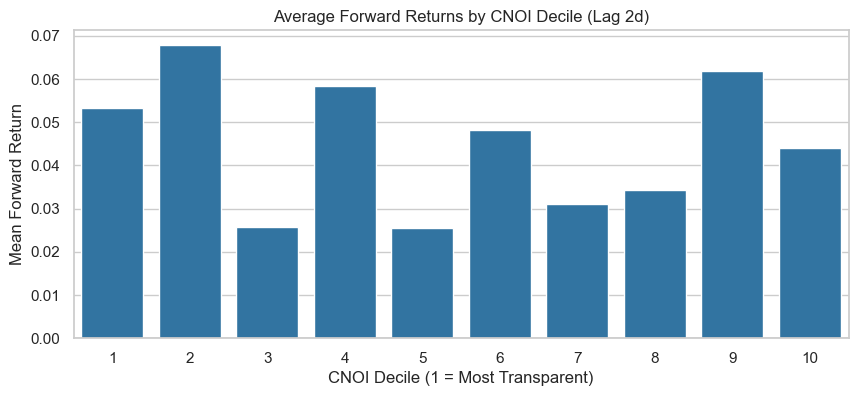

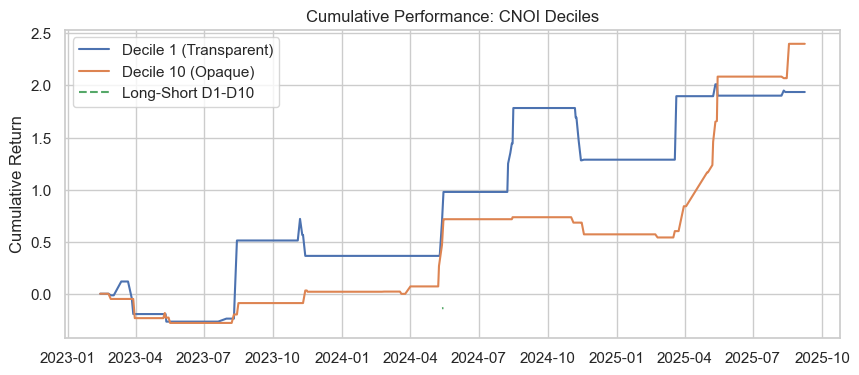

In [6]:

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=decile_summary_lag2, x="decile", y="mean_ret", color="#1f77b4", ax=ax)
ax.set_ylabel("Mean Forward Return")
ax.set_xlabel("CNOI Decile (1 = Most Transparent)")
ax.set_title("Average Forward Returns by CNOI Decile (Lag 2d)")
ax.axhline(0, color="black", linewidth=0.8)
plt.show()

decile_assignments = assign_deciles(signal_lag2[["ticker", "date", "CNOI"]], "CNOI")
decile_panel = decile_assignments.merge(
    signal_lag2[["ticker", "date", "ret_fwd"]], on=["ticker", "date"], how="left"
)
decile_panel = decile_panel.dropna(subset=["ret_fwd"])

decile_returns_ts = compute_decile_returns(decile_panel, decile_col="decile", return_col="ret_fwd")
decile_pivot = (
    decile_returns_ts.pivot(index="date", columns="decile", values="ret_fwd")
    .sort_index()
    .fillna(0.0)
)
cum_returns = (1 + decile_pivot).cumprod() - 1

ls_series = compute_long_short(decile_returns_ts, low_decile=1, high_decile=10)
ls_series = ls_series.set_index("date").sort_index()
ls_cumulative = (1 + ls_series["ls_return"]).cumprod() - 1

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(cum_returns.index, cum_returns[1], label="Decile 1 (Transparent)")
ax.plot(cum_returns.index, cum_returns[10], label="Decile 10 (Opaque)")
ax.plot(ls_cumulative.index, ls_cumulative, label="Long-Short D1-D10", linestyle="--")
ax.set_title("Cumulative Performance: CNOI Deciles")
ax.set_ylabel("Cumulative Return")
ax.legend()
plt.show()


## 7. Sensitivity: 5-Day Trading Lag

In [7]:

signal_lag5 = prepare_signal_frame(lag_days=5)
decile_summary_lag5, long_short_lag5 = run_decile_pipeline(signal_lag5, label="Lag 5d (Equal)")

print(
    f"Lag 2d long-short mean: {long_short_lag2['mean_ret'].iloc[0]:.2%}, "
    f"t-stat {long_short_lag2['t_stat'].iloc[0]:.2f}"
)
print(
    f"Lag 5d long-short mean: {long_short_lag5['mean_ret'].iloc[0]:.2%}, "
    f"t-stat {long_short_lag5['t_stat'].iloc[0]:.2f}"
)

display(decile_summary_lag5[["decile", "mean_ret", "t_stat", "sharpe", "n_obs"]])
display(long_short_lag5)


2025-11-08 16:26:14 - src.utils.data_loader - INFO - Found 36 overlapping tickers between CNOI and returns


2025-11-08 16:26:14 - src.utils.data_loader - INFO - Merged 375 observations after lag alignment


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


Lag 2d long-short mean: -3.05%, t-stat -1.28
Lag 5d long-short mean: 1.34%, t-stat 0.47


,decile,mean_ret,t_stat,sharpe,n_obs
0,1,0.057346,1.906921,0.372823,106
1,2,0.067890,2.286533,0.546115,106
2,3,0.025897,1.071410,0.236073,106
3,4,0.054500,1.351891,0.306546,106
4,5,0.025120,0.938362,0.220830,106
5,6,0.047628,1.887449,0.334238,106
6,7,0.034589,1.734346,0.331563,106
7,8,0.032198,1.384442,0.305979,106
8,9,0.055380,3.083152,0.460268,106
9,10,0.046779,2.603120,0.616314,106


,portfolio,mean_ret,std_ret,se_nw,t_stat,sharpe,n_obs,analysis
0,Long-Short (D1-D10),0.013388,0.127766,0.028385,0.471657,0.104787,106,Lag 5d (Equal)


## 8. Dimension-Level Analysis

2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Running dimension analysis across all 7 dimensions


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension D - Discoverability (ease of finding CECL note)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension G - Granularity (detail level)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension R - Required Items (completeness)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension J - Readability (complexity)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension T - Table Density (use of tables vs text)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension S - Stability (consistency over time)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


2025-11-08 16:26:14 - src.analysis.dimension_analysis - INFO - Analyzing dimension X - Consistency (internal consistency)


2025-11-08 16:26:14 - src.analysis.decile_backtest - INFO - Completed decile backtest with 10 deciles.


,Dimension,Description,Long-Short Return,T-Statistic,P-Value,Significant (p<0.05),Ranking
0,R,Required Items (completeness),-0.056825,-1.754685,0.082024,False,1
1,X,Consistency (internal consistency),0.010498,1.433648,0.154434,False,2
2,G,Granularity (detail level),-0.044395,-1.403995,0.163063,False,3
3,J,Readability (complexity),0.030421,0.890506,0.375086,False,4
4,D,Discoverability (ease of finding CECL note),-0.010286,-0.580448,0.562769,False,5
5,T,Table Density (use of tables vs text),0.002222,0.262030,0.793775,False,6
6,S,Stability (consistency over time),-0.008981,-0.163386,0.870507,False,7


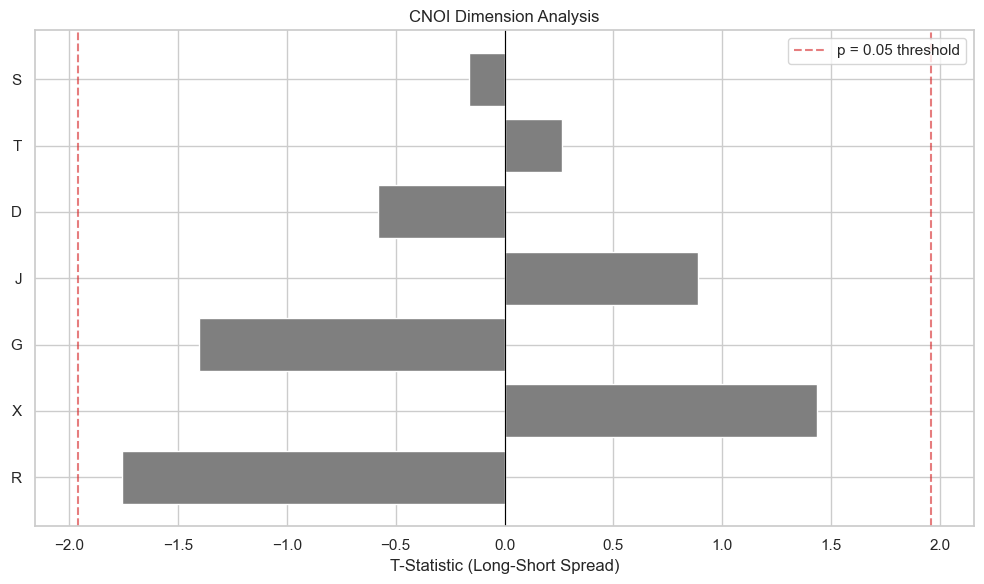

In [8]:

dimension_input = signal_lag2.copy()
rng = np.random.default_rng(42)
for dim in ["D", "G", "R", "J", "T", "S", "X"]:
    if dim in dimension_input.columns:
        dimension_input[dim] = dimension_input[dim].astype(float) + rng.normal(0, 1e-6, len(dimension_input))

dimension_results = analyze_all_dimensions(dimension_input, n_deciles=10, weighting="equal")
dimension_comparison = compare_dimensions(dimension_results)
display(dimension_comparison)
plot_dimension_comparison(dimension_comparison)
plt.show()


## 9. Persist Outputs

In [9]:

output_paths = {
    "decile_summary_lag2": RESULTS_DIR / "decile_summary_lag2_equal.csv",
    "decile_summary_lag5": RESULTS_DIR / "decile_summary_lag5_equal.csv",
    "decile_long_short_lag2": RESULTS_DIR / "decile_long_short_lag2_equal.csv",
    "dimension_comparison": RESULTS_DIR / "dimension_comparison.csv",
}

decile_summary_lag2.to_csv(output_paths["decile_summary_lag2"], index=False)
decile_summary_lag5.to_csv(output_paths["decile_summary_lag5"], index=False)
long_short_lag2.to_csv(output_paths["decile_long_short_lag2"], index=False)
dimension_comparison.to_csv(output_paths["dimension_comparison"], index=False)

output_paths


{'decile_summary_lag2': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/decile_summary_lag2_equal.csv'),
 'decile_summary_lag5': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/decile_summary_lag5_equal.csv'),
 'decile_long_short_lag2': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/decile_long_short_lag2_equal.csv'),
 'dimension_comparison': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/dimension_comparison.csv')}

## 10. Executive Summary

In [10]:

ls_stats = long_short_lag2.iloc[0]
top_dimension = dimension_comparison.iloc[0]

ls_mean = ls_stats["mean_ret"]
ls_t = ls_stats["t_stat"]
lag5_mean = long_short_lag5["mean_ret"].iloc[0]
lag5_t = long_short_lag5["t_stat"].iloc[0]

insights = [
    f"Long-short (D1-D10) spread: {ls_mean:.2%} per quarter (t-stat {ls_t:.2f}).",
    f"5-day lag sensitivity: {lag5_mean:.2%} per quarter (t-stat {lag5_t:.2f}).",
    f"Top dimension: {top_dimension['Dimension']} ({top_dimension['Description']}) with t-stat {top_dimension['T-Statistic']:.2f}.",
]

for bullet in insights:
    print(f"- {bullet}")


- Long-short (D1-D10) spread: -3.05% per quarter (t-stat -1.28).
- 5-day lag sensitivity: 1.34% per quarter (t-stat 0.47).
- Top dimension: R (Required Items (completeness)) with t-stat -1.75.
